# pydca demo

## MSA Trimming
Here we show how to use pydca as a library. We start with by importing pydca or selected modules within pydca.

In [2]:

"""pydca demo

Author: Mehari B. Zerihun
"""

# import pydca and/or selected modules
import pydca
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities


rna_msa_file = 'examples/MSA_RF00167.fa'
rna_refseq_file = 'examples/ref_RF00167.fa'

# create MSATrimmer instance 
trimmer = msa_trimmer.MSATrimmer(
    rna_msa_file, biomolecule='rna', 
    refseq_file=rna_refseq_file,
)

trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)

#write trimmed msa to file in FASTA format
trimmed_data_outfile = 'MSA_RF00167_Trimmed.fa'
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))
        


In the above, we have imported pydca or selected modules from pydca. Then we defined two variables `rna_msa_file` and `rna_refseq_file` that contain paths to an RNA MSA file and its reference sequence, respectively. Following that we created an MSATrimmer instance which enabled us to trim the MSA file. Finally, we write the trimmed MSA data to an output file `MSA_RF00167_Trimmed.fa` in FASTA format. To trim protein sequences we just need to change `biomolecule='rna'`  to `biomolecule='protein'` and provide the respective MSA and reference sequence files. Next we carry out DCA computations using the trimmed MSA saved in `MSA_RF00167_Trimmed.fa`

## DCA Computation Using Pseudolikelihood Maximization Algorithm (plmDCA)

In [3]:
# Compute DCA scores using Pseudolikelihood maximization algorithm

plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'rna',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)

# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()

In the above, we created a PlmDCA instance `plmdca_inst`  for RNA. Notice that we used the trimmed MSA data we obtained before.  We also set the values of optional parameters. The optional parameters `num_threads` is set to 10. If `pydca` is installed without OpenMP support, we cannot set the number of threads more than one. Finally we computed the DCA scores from the Frobenius norm of the couplings by calling the `compute_sorted_FN_APC()` method on `plmdca_inst`. This action returns the average product corrected (APC) DCA scores. Lets print the top five site pairs and their DCA scores.

In [4]:
for site_pair, score in plmdca_FN_APC[:5]:
    print(site_pair, score)

(45, 55) 2.579418696746083
(44, 56) 2.5577589690195426
(16, 28) 2.538282350688918
(17, 27) 2.509827587609273
(43, 57) 2.4455233021499185


We have displayed the top five site pairs ranked by their DCA scores. The first column is a tuple of site-pairs and the second column contains the DCA scores obtained from the Frobenius norm of the couplings. Note that the site pairs are arranged in the form (i, j) such that j > i.

## DCA Computation Using Mean-Field Algorithm (mfDCA)

In [5]:
#create mean-field DCA instance 
mfdca_inst = meanfield_dca.MeanFieldDCA(
    trimmed_data_outfile,
    'rna',
    pseudocount = 0.5,
    seqid = 0.8,

)

# Compute average product corrected Frobenius norm of the couplings
mfdca_FN_APC = mfdca_inst.compute_sorted_FN_APC()

In the above, we created a mean-field DCA instance `mfdca_inst`. We set the optional parameters `pseudocount` and `seqid` to be `0.5` and `0.8`. Like in the plmDCA we computed the DCA scores from the Frobenius norm of the couplings and average product corrected. using `compute_sorted_FN_APC` metho of `mfdca_inst`. Lets print the top five ranked site pairs.

In [6]:
for site_pair, score in mfdca_FN_APC[:5]:
    print(site_pair, score)

(44, 56) 4.290005464965937
(16, 28) 4.210860173400806
(17, 27) 4.207758141824402
(45, 55) 4.190480172499375
(43, 57) 4.039065434604404


## Plotting Contact Map and True Positive Rates

Next  we plot the contact map and true positive rates of DCA scores computed using the two methods (plmDCA and mfDCA)
### Contact Map and True Positive Rate for PlmDCA Scores

In [8]:
plmdca_visualizer = contact_visualizer.DCAVisualizer('rna', 'x', '1y26',
    refseq_file = rna_refseq_file,
    sorted_dca_scores = plmdca_FN_APC,
    linear_dist = 4,
    contact_dist = 8.0,
)


	You didn't supply RNA secondary structure file.


Now we have created an instance of `DCAVisualizer`. It takes the type of biomolecule ('rna') , PDB chain ('x'), PDB ID ('1y26'). In addition we have specified reference sequence file, list of sorted DCA scores, linear distance and contact distnace.  When we execute the above cell we see a warning `You didn't supply RNA secondary structure file`. Since supplying an RNA secondary structure file is optional, we can ignore the warning. Next we plot the contact map and true postive rates.

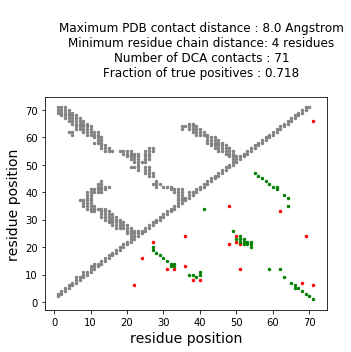

In [9]:
contact_map_data = plmdca_visualizer.plot_contact_map()

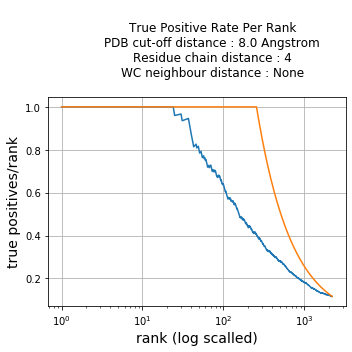

In [10]:
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()

### Contact Map and True Positive Rate for Mean-Field DCA Scores

Like DCA scores computed using the plmDCA algorithm, we can visualize contact map and true positive rates for mfDCA computed DCA scores as shown below.

In [11]:
mfdca_visualizer = contact_visualizer.DCAVisualizer('rna', 'x', '1y26',
    refseq_file = rna_refseq_file,
    sorted_dca_scores = mfdca_FN_APC,
    linear_dist = 4,
    contact_dist = 8.0,
)


	You didn't supply RNA secondary structure file.


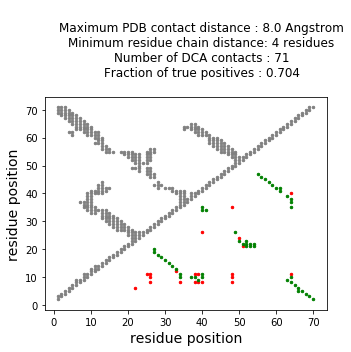

In [12]:
contact_map_data = mfdca_visualizer.plot_contact_map()

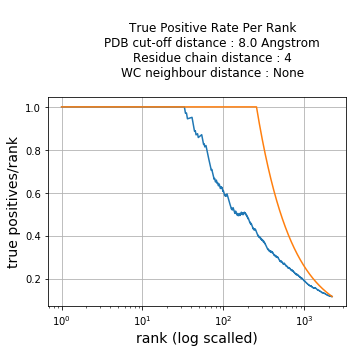

In [13]:
tp_rate_data = mfdca_visualizer.plot_true_positive_rates()

### Computing Fields and Couplings

We can also compute the fields and couplings of the global probability model. That is the $h_{i}$'s and $J_{ij}$'s in the expression $P(a_{1}, a_{2}, ..., a_{L}) =\frac{1}{Z}\exp(\sum_{i<j} J_{ij}(a_{i}, a_{j}) + \sum_{i} h_{i}(a_{i}))$. In pydca these parameters can be computed using either the mean-field DCA algorithm or the pseudolikelihood maximization DCA algorithm.

In [26]:
fields_plm, couplings_plm = plmdca_inst.compute_params(ranked_by='di_apc', num_site_pairs=100)


Or using the mean-field algorithm as:

In [27]:
fields_mf, couplings_mf = mfdca_inst.compute_params(ranked_by='fn_apc', num_site_pairs=200)

When we compute the fields and couplings, we can specify a ranking method for the couplings so that the site pairs for the couplings are ordered accourding to the ranking method.  In the above examples, we used 'di_apc' for the PlmDCA and 'fn_apc' for the mfDCA algorithms. 'di_apc' stands for the ranking method is according average product corrected direct information scores. Whereas 'fn_apc' implies average corrected Frobenius norm.